In [114]:
import pandas as pd
import numpy as np
import eurostat
from sklearn.preprocessing import LabelEncoder,StandardScaler, scale
from sklearn.model_selection import train_test_split  # Libraries for ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics,tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
# Modal split of inland passenger transport
# Unit of measure (% based on passenger-kilometres) : one passenger-km is one passenger transported over one kilometre
# https://ec.europa.eu/eurostat/databrowser/view/TRAN_HV_PSMOD__custom_2638259/bookmark/table?lang=en&bookmarkId=2d735f97-a7d6-4b24-bc27-a6c8e21db6a7
# Licence: https://ec.europa.eu/eurostat/about-us/policies/copyright
mldf = eurostat.get_data_df('TRAN_HV_PSMOD',True)                                                                 
mldf.head()
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

mldf.head()

,freq,unit,vehicle,geo\TIME_PERIOD,1990_value,1990_flag,1991_value,1991_flag,1992_value,1992_flag,...,2017_value,2017_flag,2018_value,2018_flag,2019_value,2019_flag,2020_value,2020_flag,2021_value,2021_flag
0,A,PC,BUS_TOT,AT,11.00,,10.60,,10.50,,...,10.00,,9.50,be,9.70,e,9.30,e,9.00,e
1,A,PC,BUS_TOT,BE,10.60,e,10.70,e,10.70,e,...,10.20,e,10.30,e,10.40,e,8.20,e,8.20,e
2,A,PC,BUS_TOT,BG,NaN,:,NaN,:,NaN,:,...,13.10,e,12.00,e,13.00,e,8.60,e,8.00,e
3,A,PC,BUS_TOT,CH,3.70,,3.90,,4.00,,...,5.90,e,5.90,e,6.10,e,5.80,e,5.90,e
4,A,PC,BUS_TOT,CY,NaN,:,NaN,:,NaN,:,...,19.00,e,18.90,e,18.50,e,12.60,e,12.70,e


In [3]:
# Tyding up mldf

# Filter columns that do not contain '_flag'
mldf = mldf.filter(regex='^(?!.*_flag)')

# Renaming columns
mldf = mldf.rename(columns={'geo\\TIME_PERIOD': 'Country_code','vehicle':'Vehicle_type'})

# Dropping not needed rows:
# From column 'Vehicle_type' we don't need 'TRN_BUS_TOT_AVD'
# From column 'Country_code' we don't need 'EU27_2020' and 'EU28'
mldf = mldf[(mldf['Vehicle_type'] != 'TRN_BUS_TOT_AVD') & ~mldf['Country_code'].isin(['EU27_2020', 'EU28'])]

# Drop rows with null values
mldf = mldf.dropna()

# Dropping columns 'freq' and 'unit' we don't need them. Unit of measurement for this dataset is percentage
mldf = mldf.drop(['freq', 'unit'], axis=1).reset_index(drop=True)

# Trimming 'BUS_TOT' to have just 'BUS'
mldf['Vehicle_type'] = mldf['Vehicle_type'].str.replace('_TOT', '')

# Concatenate 'Country_code' and 'Vehicle_type'
mldf['Country_Vehicle'] = mldf['Country_code'] + '_' + mldf['Vehicle_type']

# Drop the original columns
mldf = mldf.drop(['Vehicle_type', 'Country_code'], axis=1)

mldf.head()

,1990_value,1991_value,1992_value,1993_value,1994_value,1995_value,1996_value,1997_value,1998_value,1999_value,...,2013_value,2014_value,2015_value,2016_value,2017_value,2018_value,2019_value,2020_value,2021_value,Country_Vehicle
0,11.00,10.60,10.50,10.70,10.60,10.90,10.70,10.90,10.90,10.70,...,9.90,9.90,9.90,9.90,10.00,9.50,9.70,9.30,9.00,AT_BUS
1,10.60,10.70,10.70,10.90,11.80,11.30,11.30,11.10,11.00,10.90,...,15.20,11.50,11.00,10.50,10.20,10.30,10.40,8.20,8.20,BE_BUS
2,3.70,3.90,4.00,3.90,4.00,3.80,3.60,3.60,5.30,5.20,...,5.70,5.80,5.90,5.90,5.90,5.90,6.10,5.80,5.90,CH_BUS
3,9.10,8.50,8.30,8.10,7.30,7.20,7.10,7.10,7.00,6.90,...,7.20,7.20,7.40,7.30,7.30,7.20,7.40,4.80,4.80,DE_BUS
4,11.30,11.10,15.20,15.30,15.50,16.60,17.40,16.90,14.10,13.90,...,9.80,9.80,9.80,9.80,10.00,9.60,9.20,6.80,7.10,DK_BUS


In [4]:
# We need to organise mldf, basically I want to have 'Year', 'Country_Vehicle' and 'value'
    
# Empty list to store results, initialising it
final_list = []

# Iterating over columns to extract the year from columns
for col in mldf.columns:
    if col.endswith('_value'):
        # Extracting each year from the columns
        year = col.split('_')[0]

        # Getting 'Vehicle_Country' for each row to get its corresponding values
        for index, row in mldf.iterrows():
            value = row[col]
            country_vehicle = row['Country_Vehicle']
            category = col.split('_')[1]  # Extract the category from the column name

            # Appending the final list as a dictionary
            final_list.append({
                'Year': year,
                'Country_Vehicle': country_vehicle,
                'Category': category,
                'Value': value
            })
            
# Converting 'final_list' to a DataFrame
Y_CV_V_df = pd.DataFrame(final_list)

# Pivot the DataFrame
Y_CV_V_df = Y_CV_V_df.pivot_table(index=['Year', 'Country_Vehicle'], columns='Category', values='Value').reset_index()
Y_CV_V_df = Y_CV_V_df.rename_axis(None, axis=1) # Index with no name as it should be
   
mldf = Y_CV_V_df.copy() #Reusing variable mldf

mldf.head()

,Year,Country_Vehicle,value
0,1990,AT_BUS,11.00
1,1990,AT_CAR,77.10
2,1990,AT_TRN,11.90
3,1990,BE_BUS,10.60
4,1990,BE_CAR,83.30


In [5]:
mldf.shape

(1728, 3)

In [6]:
# Dataset will be used in the second part of this section
mldf1a = mldf.copy() 

In [7]:
# Creating mdf1 for stats

mldf1 = mldf.copy()

In [8]:
# Pivot the DataFrame
mldf1 = mldf1.pivot(index='Year', columns='Country_Vehicle', values='value').reset_index()
mldf1 = mldf1.rename_axis(None, axis=1)
mldf1.head()

,Year,AT_BUS,AT_CAR,AT_TRN,BE_BUS,BE_CAR,BE_TRN,CH_BUS,CH_CAR,CH_TRN,...,PL_TRN,PT_BUS,PT_CAR,PT_TRN,SE_BUS,SE_CAR,SE_TRN,SI_BUS,SI_CAR,SI_TRN
0,1990,11.00,77.10,11.90,10.60,83.30,6.10,3.70,82.10,14.20,...,30.50,18.40,71.50,10.10,9.50,84.10,6.50,30.60,62.70,6.70
1,1991,10.60,77.00,12.40,10.70,83.30,6.10,3.90,81.10,15.00,...,24.60,18.60,71.40,9.90,9.50,84.70,5.90,29.30,66.40,4.30
2,1992,10.50,77.00,12.50,10.70,83.30,6.00,4.00,81.40,14.60,...,20.30,22.70,68.20,9.00,9.40,84.80,5.80,23.00,73.90,3.00
3,1993,10.70,77.20,12.10,10.90,83.30,5.90,3.90,80.90,15.20,...,17.70,19.30,72.20,8.50,9.30,84.40,6.30,21.10,75.80,3.10
4,1994,10.60,77.80,11.60,11.80,82.60,5.60,4.00,79.80,16.20,...,15.60,17.90,74.30,7.80,9.30,84.40,6.30,20.40,76.60,3.00


In [9]:
# Dataset for Unsupervised ML models
mldf2 = mldf1.copy()

In [10]:
# sdf1.describe(include='all').T # Transposing columns to see each Country_Vehicle
# passing the stats into 'mldf1' dataframe
mldf1 = (mldf1.describe(include='all').T).reset_index().rename_axis(None, axis=1).copy()

# Dropping first row we don't need Years we already now that year range goes from 1990 to 2021
mldf1 = mldf1.drop(0)

# Renaming columns
mldf1 = mldf1.rename(columns={'index': 'Country_Vehicle'}).drop(['unique', 'top','freq','count','std','25%','50%','75%','max','min'], axis=1).sort_values(by='mean', ascending=False).reset_index(drop=True)

mldf1

,Country_Vehicle,mean
0,NL_CAR,86.12
1,FR_CAR,85.38
2,DE_CAR,85.35
3,LU_CAR,84.58
4,PT_CAR,84.52
5,FI_CAR,83.88
6,SE_CAR,83.50
7,IE_CAR,82.85
8,SI_CAR,82.72
9,IT_CAR,82.16


In [11]:
def highlight_countries(row):
    styles = [''] * len(row)
    
    # Highlight 'IE' in yellow
    if row['Country_Vehicle'].startswith('IE'):
        styles = ['background-color: yellow'] * len(row)
    
    # Highlight 'HU' in lightgreen
    elif row['Country_Vehicle'].startswith('HU'):
        styles = ['background-color: lightgreen'] * len(row)
    
    return styles

# Apply the highlighting function to the DataFrame
mldf1 = mldf1.style.apply(highlight_countries, axis=1)

mldf1

,Country_Vehicle,mean
0,NL_CAR,86.121875
1,FR_CAR,85.378125
2,DE_CAR,85.346875
3,LU_CAR,84.575000
4,PT_CAR,84.515625
5,FI_CAR,83.878125
6,SE_CAR,83.496875
7,IE_CAR,82.850000
8,SI_CAR,82.718750
9,IT_CAR,82.156250


In [12]:
# Modify the code to filter based on substrings
mldf = mldf[mldf['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]
mldf.reset_index(drop=True, inplace=True)

# Outlier Analysis:

In [13]:
# # Box plot to identify outliers
# sns.boxplot(x='Luas_Line', y='VALUE', data=df)
# plt.show()


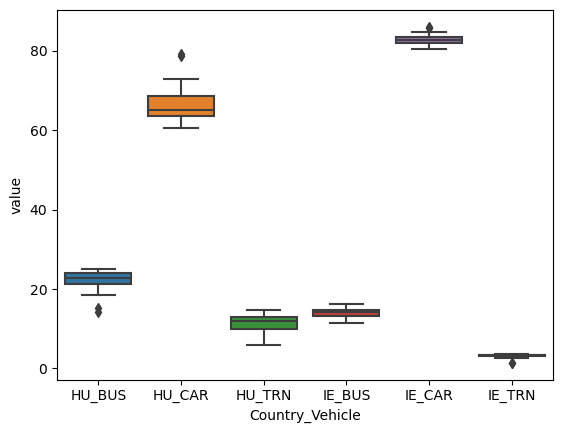

In [14]:
# Box plot to identify outliers
sns.boxplot(x='Country_Vehicle', y='value', data=mldf)

plt.show()


No need to remove outliers

In [15]:
mldf

,Year,Country_Vehicle,value
0,1990,HU_BUS,24.80
1,1990,HU_CAR,60.50
2,1990,HU_TRN,14.70
3,1990,IE_BUS,11.50
4,1990,IE_CAR,84.90
...,...,...,...
187,2021,HU_CAR,79.30
188,2021,HU_TRN,6.40
189,2021,IE_BUS,13.00
190,2021,IE_CAR,85.70


In [16]:
# Move the 'Year' column to the second position
mldf.insert(1, 'Year', mldf.pop('Year'))

In [17]:
# Counting the values that each year has:
year_counts = mldf['Year'].value_counts().sort_index()
year_counts

Year
1990    6
1991    6
1992    6
1993    6
1994    6
1995    6
1996    6
1997    6
1998    6
1999    6
2000    6
2001    6
2002    6
2003    6
2004    6
2005    6
2006    6
2007    6
2008    6
2009    6
2010    6
2011    6
2012    6
2013    6
2014    6
2015    6
2016    6
2017    6
2018    6
2019    6
2020    6
2021    6
Name: count, dtype: int64

In [18]:
mldf

,Country_Vehicle,Year,value
0,HU_BUS,1990,24.80
1,HU_CAR,1990,60.50
2,HU_TRN,1990,14.70
3,IE_BUS,1990,11.50
4,IE_CAR,1990,84.90
...,...,...,...
187,HU_CAR,2021,79.30
188,HU_TRN,2021,6.40
189,IE_BUS,2021,13.00
190,IE_CAR,2021,85.70


I need to see Country_Vehicle classes

In [19]:
mldf_1990 = mldf[(mldf['Year'] == '1990')].copy()
mldf_1990.reset_index(drop=True, inplace=True)
mldf_1990

,Country_Vehicle,Year,value
0,HU_BUS,1990,24.80
1,HU_CAR,1990,60.50
2,HU_TRN,1990,14.70
3,IE_BUS,1990,11.50
4,IE_CAR,1990,84.90
5,IE_TRN,1990,3.60


In [20]:
mldf

,Country_Vehicle,Year,value
0,HU_BUS,1990,24.80
1,HU_CAR,1990,60.50
2,HU_TRN,1990,14.70
3,IE_BUS,1990,11.50
4,IE_CAR,1990,84.90
...,...,...,...
187,HU_CAR,2021,79.30
188,HU_TRN,2021,6.40
189,IE_BUS,2021,13.00
190,IE_CAR,2021,85.70


In [21]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Sex' column
mldf['Country_Vehicle'] = le.fit_transform(mldf['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
mldf

,Country_Vehicle,Year,value
0,0,1990,24.80
1,1,1990,60.50
2,2,1990,14.70
3,3,1990,11.50
4,4,1990,84.90
...,...,...,...
187,1,2021,79.30
188,2,2021,6.40
189,3,2021,13.00
190,4,2021,85.70


We can clearly see encoding equivalence

In [22]:
mldf_1990

,Country_Vehicle,Year,value
0,HU_BUS,1990,24.80
1,HU_CAR,1990,60.50
2,HU_TRN,1990,14.70
3,IE_BUS,1990,11.50
4,IE_CAR,1990,84.90
5,IE_TRN,1990,3.60


In [23]:
X = mldf.iloc[:, [1,2]].values # Dependent variables
y = mldf.iloc[:, 0].values # Target variable

In [24]:
X

array([['1990', 24.8],
       ['1990', 60.5],
       ['1990', 14.7],
       ['1990', 11.5],
       ['1990', 84.9],
       ['1990', 3.6],
       ['1991', 23.4],
       ['1991', 63.2],
       ['1991', 13.3],
       ['1991', 11.9],
       ['1991', 84.3],
       ['1991', 3.7],
       ['1992', 22.9],
       ['1992', 63.9],
       ['1992', 13.2],
       ['1992', 12.3],
       ['1992', 84.2],
       ['1992', 3.5],
       ['1993', 23.2],
       ['1993', 64.5],
       ['1993', 12.4],
       ['1993', 12.6],
       ['1993', 83.8],
       ['1993', 3.6],
       ['1994', 23.5],
       ['1994', 64.3],
       ['1994', 12.2],
       ['1994', 13.6],
       ['1994', 83.0],
       ['1994', 3.4],
       ['1995', 23.6],
       ['1995', 64.4],
       ['1995', 12.0],
       ['1995', 13.6],
       ['1995', 83.0],
       ['1995', 3.4],
       ['1996', 25.0],
       ['1996', 63.2],
       ['1996', 11.8],
       ['1996', 13.5],
       ['1996', 83.3],
       ['1996', 3.3],
       ['1997', 24.0],
       ['1997', 64

In [25]:
y

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

## Splitting the dataset into the Training set and Test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Ridge Regression

In [27]:
from sklearn.linear_model import Ridge

# Train the Ridge() mode by calling a fit() method
ridge = Ridge().fit(X_train, y_train)

# Display the score by using ridge object
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.00
Test set score: -0.06


## Feature Scaling

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
from sklearn.linear_model import Ridge

# Train the Ridge() mode by calling a fit() method
ridge = Ridge().fit(X_train, y_train)

# Display the score by using ridge object
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.00
Test set score: -0.06


# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [30]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Predicting the Test and set results

In [31]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

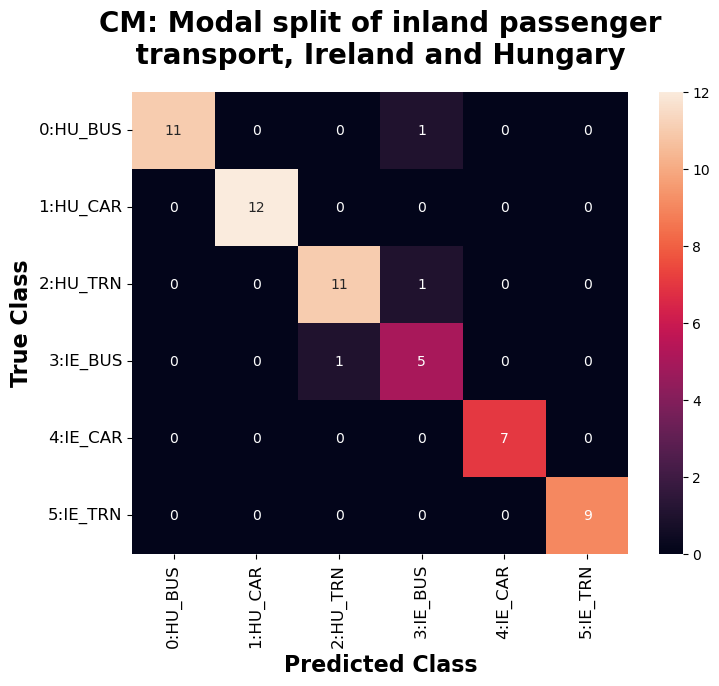

In [32]:
# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()

In [33]:
# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

tree=metrics.accuracy_score(y_test, y_pred)*100

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      1.00      1.00        12
           2       0.92      0.92      0.92        12
           3       0.71      0.83      0.77         6
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         9

    accuracy                           0.95        58
   macro avg       0.94      0.94      0.94        58
weighted avg       0.95      0.95      0.95        58

Classifier Accuracy: 94.83


In [34]:
# instantiate the classifier 
rfc = RandomForestClassifier(n_estimators=10,random_state=0) # Setting 10 trees

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))
randomforest = accuracy_score(y_test, y_pred)*100

Model accuracy score with 10 decision-trees : 93.10


In [35]:
# Check the number of decision trees in the Random Forest
num_decision_trees = rfc.n_estimators

# Print the number of decision trees
print(f'Number of decision trees in the Random Forest: {num_decision_trees}')


Number of decision trees in the Random Forest: 10


## Creating a K-Nearest Neighbor Classifier

In [36]:
neighbors = np.arange(1, 20)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [37]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_train, y_train)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      # Save the score value in the train_accuracy array

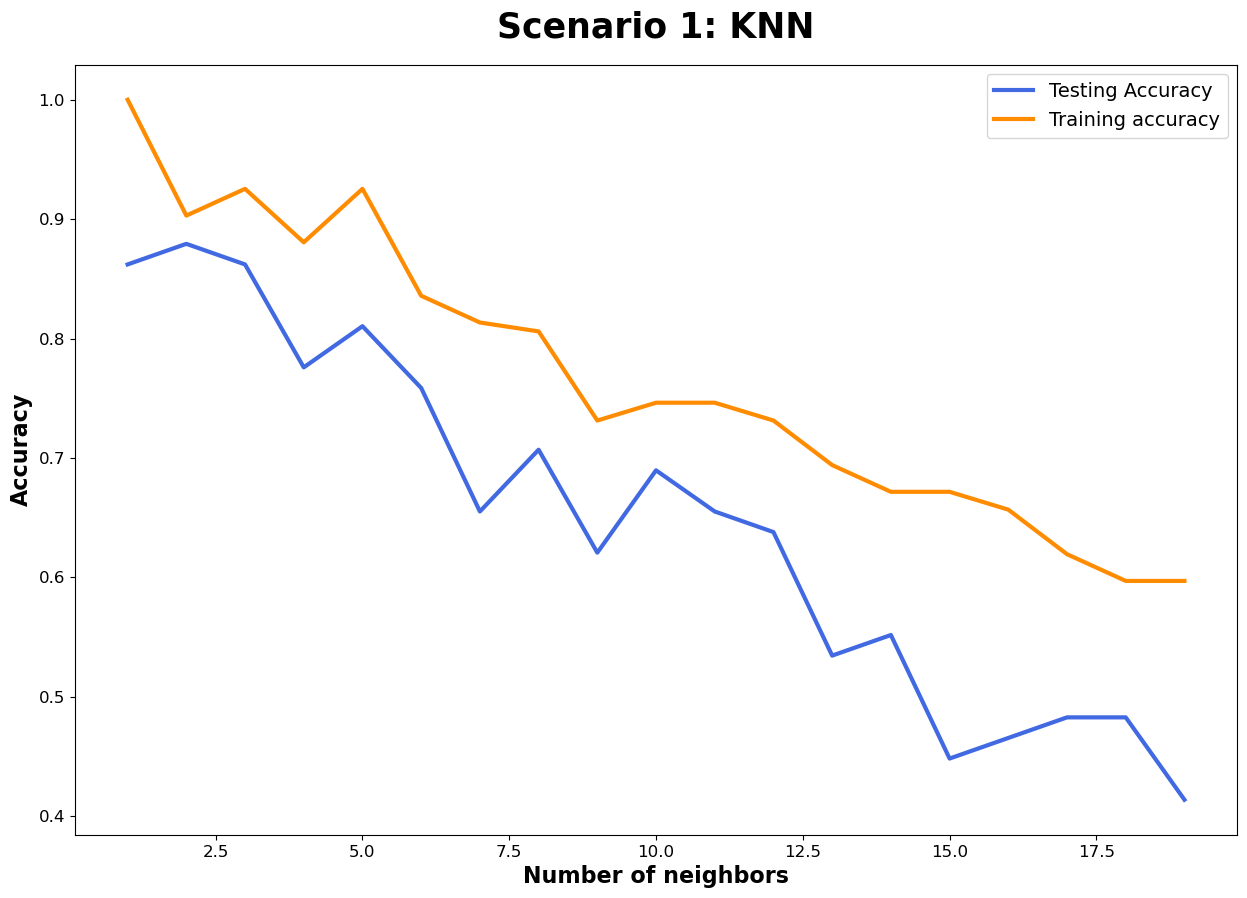

In [38]:
plt.figure(figsize=(15, 10))
plt.title('Scenario 1: KNN',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', linewidth=3, color='royalblue')
plt.plot(neighbors, train_accuracy, label='Training accuracy', linewidth=3, color='darkorange')

plt.xlabel('Number of neighbors',fontsize=16, fontweight='bold')
plt.ylabel('Accuracy',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend( loc='best', fontsize=14)
plt.show()

In [39]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the model
knn.fit(X_train, y_train)   

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)   

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)  

In [40]:
# Display the test accuracy

print('Test accuracy = ', round(test_accuracy*100,2))
KNN=test_accuracy*100

Test accuracy =  86.21


# Parameter tunning GridSearch

In [41]:
# scaling the features

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## Model Building

In [42]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


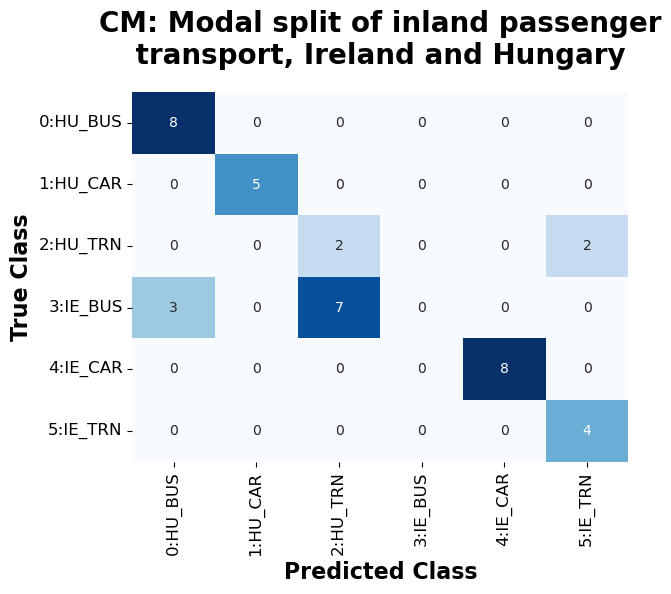

In [43]:
# confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

# Generate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Create a heatmap of the confusion matrix

sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False, xticklabels=class_labels, yticklabels=class_labels) 
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()


In [44]:

# Printing classification report
print(classification_report(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

svc = metrics.accuracy_score(y_test, y_pred)*100

# precision
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      1.00      1.00         5
           2       0.22      0.50      0.31         4
           3       0.00      0.00      0.00        10
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         4

    accuracy                           0.69        39
   macro avg       0.60      0.75      0.66        39
weighted avg       0.57      0.69      0.62        39

accuracy 0.6923076923076923
precision 0.5736855736855737
recall 0.6923076923076923


## Grid Search to Find Optimal Hyperparameters

In [45]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}]#,
                


# specify model
model = SVC(kernel = "rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring = 'accuracy', 
                        cv = folds, 
                        verbose = 4, # Changing verbose from 1 to 4, to display records :)
                        return_train_score = True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, gamma=0.01;, score=(train=0.533, test=0.387) total time=   0.0s
[CV 2/5] END C=1, gamma=0.01;, score=(train=0.377, test=0.290) total time=   0.0s
[CV 3/5] END C=1, gamma=0.01;, score=(train=0.361, test=0.355) total time=   0.0s
[CV 4/5] END C=1, gamma=0.01;, score=(train=0.382, test=0.400) total time=   0.0s
[CV 5/5] END C=1, gamma=0.01;, score=(train=0.472, test=0.267) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001;, score=(train=0.197, test=0.129) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001;, score=(train=0.205, test=0.097) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001;, score=(train=0.189, test=0.161) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001;, score=(train=0.220, test=0.200) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001;, score=(train=0.195, test=0.100) total time=   0.0s
[CV 1/5] END C=1, gamma=0.0001;, score=(train=0.197, test=0.129) total time=   0.0s
[CV 2/5] END C=1, gamma=0.0001

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [46]:
## cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

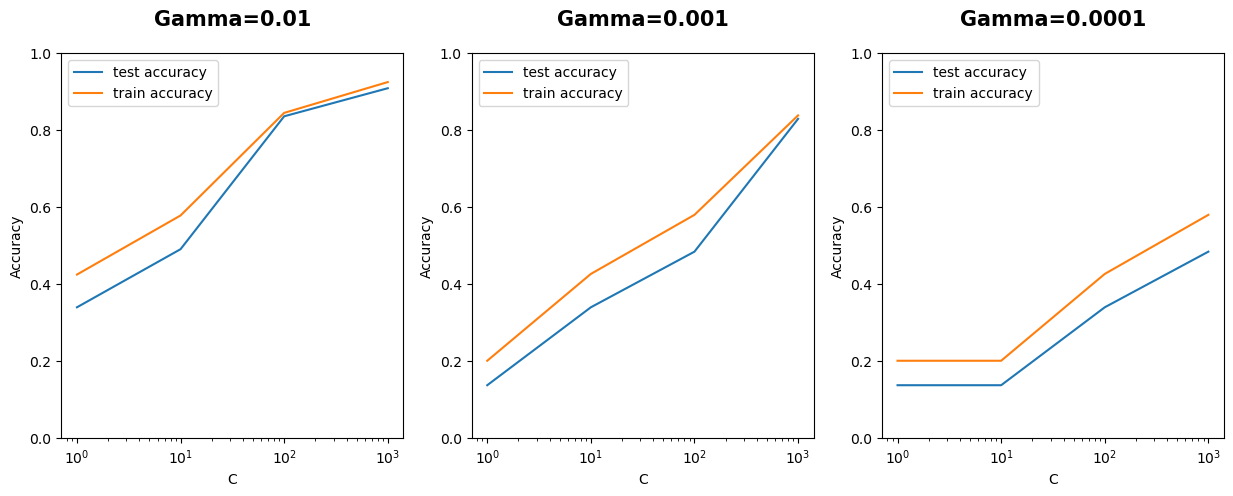

In [47]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,5))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [48]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('Tree:',tree)
print('RF:',randomforest)
print('KNN:',KNN)
print('SVC:',svc)
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Tree: 94.82758620689656
RF: 93.10344827586206
KNN: 86.20689655172413
SVC: 69.23076923076923
The best test score is 0.9088172043010753 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}


Gamma = 0.01 overfitted model <br>

Gamma=0.001 less overfitted model <br>

Gamma=0.0001 fitten model <br>

This plot reveals some interesting insights:
- **High values of gamma** lead to **overfitting** (especially at high values of C); note that the training accuracy at gamma=0.01 and C=1000 reaches almost 99% 
- The **training score increases with higher gamma**, though the **test scores are comparable** (at sufficiently high cost, i.e. C > 10)
- The least amount of overfitting (i.e. difference between train and test accuracy) occurs at low gamma, i.e. a quite *simple non-linear model*

# Conclusion:
We can see that Gamma = 0.0001 Graph is at around 60% accuracy whereas Gamma Graps at 0.01 and 0.001 are hiting 80% accuracy and above.

# Increasing dataset to get higher accuracy at Gamma = 0.0001.

In [49]:
# Modify the code to filter based on substrings
mldf1a = mldf1a[mldf1a['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]
mldf1a.reset_index(drop=True, inplace=True)

In [50]:
def break_into_trimesters(row):
    # Define the fixed weights for trimesters
    weights = [0.23, 0.27,0.24 , 0.26] # weights = 1

    # Create a dataframe to store the result
    result_df = pd.DataFrame({'Trimester': range(1, 5),
                              'Weight': weights})

    # Calculate the value for each trimester
    result_df['value'] = row['value'] * result_df['Weight']

    # Merge the result with the original row
    result_df['Country_Vehicle'] = row['Country_Vehicle']
    result_df['Year'] = row['Year']

    return result_df
# Apply the function to each row of the dataframe
mldf1a = pd.concat(mldf1a.apply(break_into_trimesters, axis=1).to_list(), ignore_index=True)

# Display the resulting dataframe
mldf1a

,Trimester,Weight,value,Country_Vehicle,Year
0,1,0.23,5.70,HU_BUS,1990
1,2,0.27,6.70,HU_BUS,1990
2,3,0.24,5.95,HU_BUS,1990
3,4,0.26,6.45,HU_BUS,1990
4,1,0.23,13.92,HU_CAR,1990
...,...,...,...,...,...
763,4,0.26,22.28,IE_CAR,2021
764,1,0.23,0.32,IE_TRN,2021
765,2,0.27,0.38,IE_TRN,2021
766,3,0.24,0.34,IE_TRN,2021


In [51]:
# Dropping the 'STATISTIC Label' column it's irrelevant for the analysis
df_col_drop = ['Trimester','Weight']
mldf1a.drop(df_col_drop ,axis=1, inplace=True) 

In [52]:
# Move the 'Year' column to the second position
mldf1a.insert(2, 'value', mldf1a.pop('value'))

In [53]:
mldf1a.head()

,Country_Vehicle,Year,value
0,HU_BUS,1990,5.70
1,HU_BUS,1990,6.70
2,HU_BUS,1990,5.95
3,HU_BUS,1990,6.45
4,HU_CAR,1990,13.92


In [54]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Sex' column
mldf1a['Country_Vehicle'] = le.fit_transform(mldf1a['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
mldf1a

,Country_Vehicle,Year,value
0,0,1990,5.70
1,0,1990,6.70
2,0,1990,5.95
3,0,1990,6.45
4,1,1990,13.92
...,...,...,...
763,4,2021,22.28
764,5,2021,0.32
765,5,2021,0.38
766,5,2021,0.34


In [55]:
X = mldf1a.iloc[:, [1,2]].values # Dependent variables
y = mldf1a.iloc[:, 0].values # Target variable

In [56]:
X

array([['1990', 5.704000000000001],
       ['1990', 6.696000000000001],
       ['1990', 5.952],
       ...,
       ['2021', 0.378],
       ['2021', 0.33599999999999997],
       ['2021', 0.364]], dtype=object)

In [57]:
y

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4,
       5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4,
       4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
       4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3,
       3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0,
       1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0,
       0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
       0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3,

## Splitting the dataset into the Training set and Test set

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Feature Scaling

In [59]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [60]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Predicting the Test and set results

In [61]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

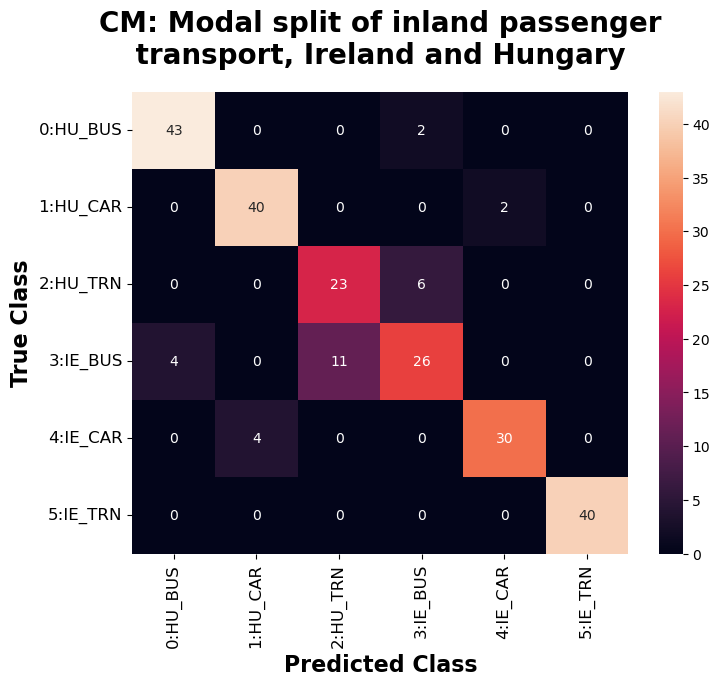

In [62]:
from sklearn.metrics import confusion_matrix

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()



In [63]:
# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

tree=metrics.accuracy_score(y_test, y_pred)*100

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.91      0.95      0.93        42
           2       0.68      0.79      0.73        29
           3       0.76      0.63      0.69        41
           4       0.94      0.88      0.91        34
           5       1.00      1.00      1.00        40

    accuracy                           0.87       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.88      0.87      0.87       231

Classifier Accuracy: 87.45


In [64]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0,verbose=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))
randomforest = accuracy_score(y_test, y_pred)*100

Model accuracy score with 10 decision-trees : 91.77


## Creating a K-Nearest Neighbor Classifier

In [65]:
neighbors = np.arange(1, 20)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [66]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_train, y_train)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      # Save the score value in the train_accuracy array

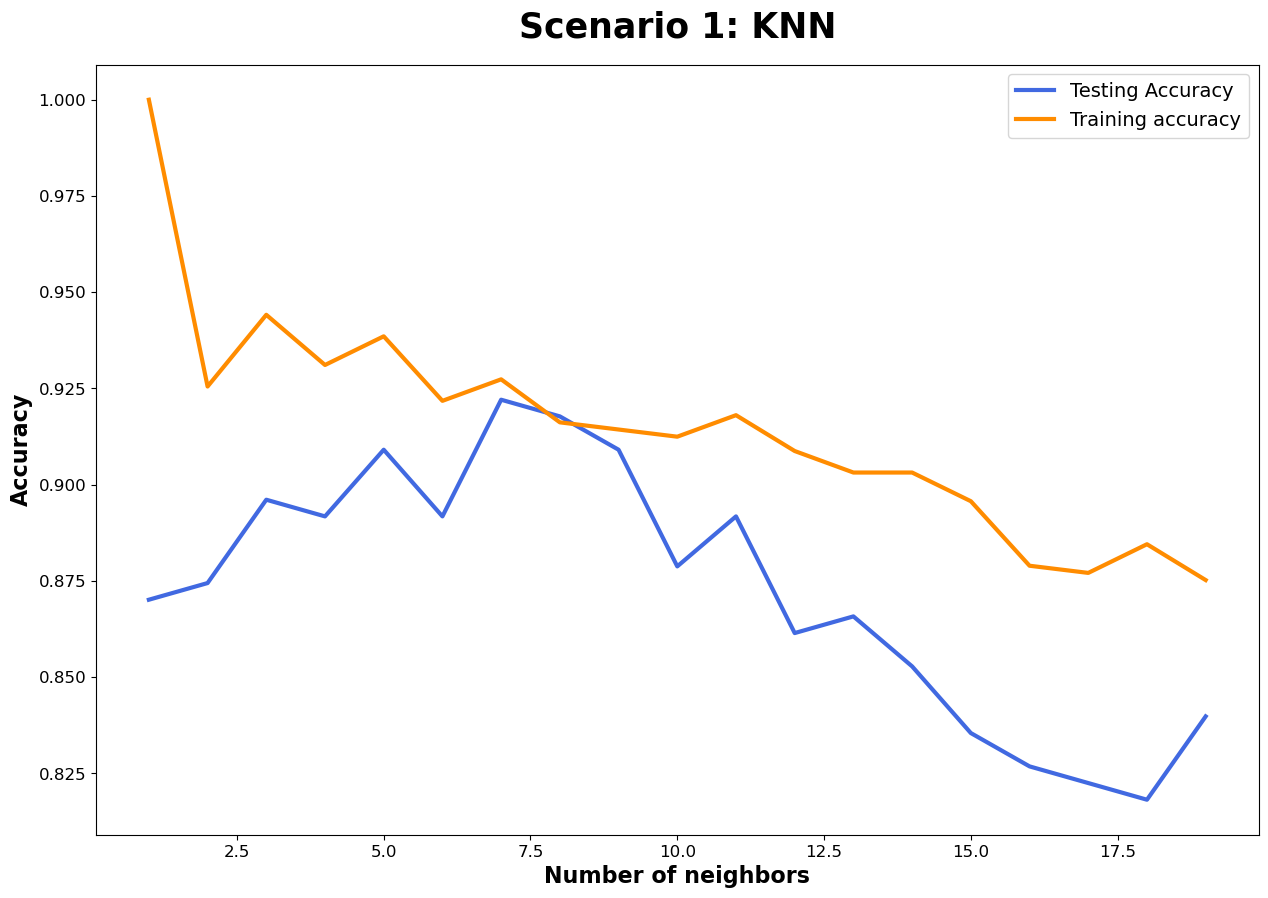

In [67]:
plt.figure(figsize=(15, 10))
plt.title('Scenario 1: KNN',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', linewidth=3, color='royalblue')
plt.plot(neighbors, train_accuracy, label='Training accuracy', linewidth=3, color='darkorange')

plt.xlabel('Number of neighbors',fontsize=16, fontweight='bold')
plt.ylabel('Accuracy',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend( loc='best', fontsize=14)
plt.show()

In [68]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 2)

# Fit the model
knn.fit(X_train, y_train)   

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)   

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)  

In [69]:
# Display the test accuracy

print('Test accuracy = ', round(test_accuracy*100,2))
KNN=test_accuracy*100

Test accuracy =  87.45


# Parameter tunning GridSearch

In [70]:
# scaling the features

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## Model Building

In [71]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


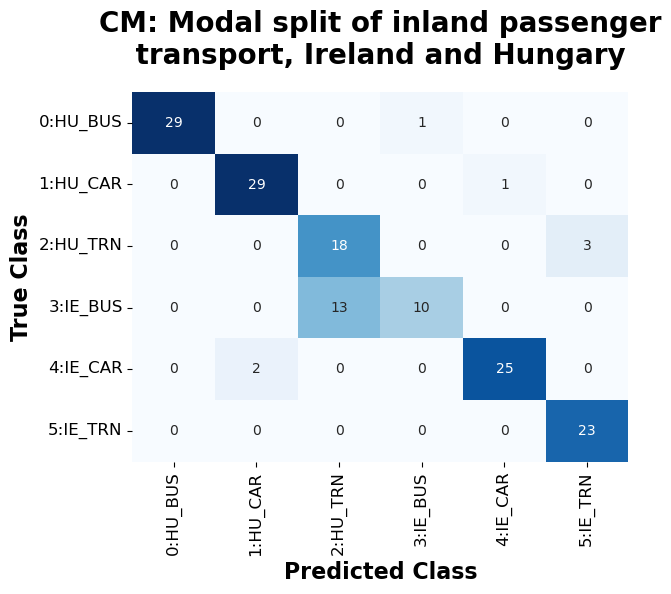

In [72]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

# Generate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Create a heatmap of the confusion matrix

sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False, xticklabels=class_labels, yticklabels=class_labels) 
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()

In [73]:

# Printing classification report
print(classification_report(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

svc = metrics.accuracy_score(y_test, y_pred)*100

# precision
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.94      0.97      0.95        30
           2       0.58      0.86      0.69        21
           3       0.91      0.43      0.59        23
           4       0.96      0.93      0.94        27
           5       0.88      1.00      0.94        23

    accuracy                           0.87       154
   macro avg       0.88      0.86      0.85       154
weighted avg       0.89      0.87      0.86       154

accuracy 0.8701298701298701
precision 0.8926938164474821
recall 0.8701298701298701


## Grid Search to Find Optimal Hyperparameters

In [74]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}]#,
                


# specify model
model = SVC(kernel = "rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring = 'accuracy', 
                        cv = folds, 
                        verbose = 4, # Changing verbose from 1 to 4, to display records :)
                        return_train_score = True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, gamma=0.01;, score=(train=0.487, test=0.366) total time=   0.0s
[CV 2/5] END C=1, gamma=0.01;, score=(train=0.356, test=0.252) total time=   0.0s
[CV 3/5] END C=1, gamma=0.01;, score=(train=0.340, test=0.333) total time=   0.0s
[CV 4/5] END C=1, gamma=0.01;, score=(train=0.354, test=0.260) total time=   0.0s
[CV 5/5] END C=1, gamma=0.01;, score=(train=0.346, test=0.295) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001;, score=(train=0.187, test=0.122) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001;, score=(train=0.356, test=0.252) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001;, score=(train=0.177, test=0.171) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001;, score=(train=0.181, test=0.146) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001;, score=(train=0.183, test=0.123) total time=   0.0s
[CV 1/5] END C=1, gamma=0.0001;, score=(train=0.187, test=0.122) total time=   0.0s
[CV 2/5] END C=1, gamma=0.0001

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [75]:
## cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

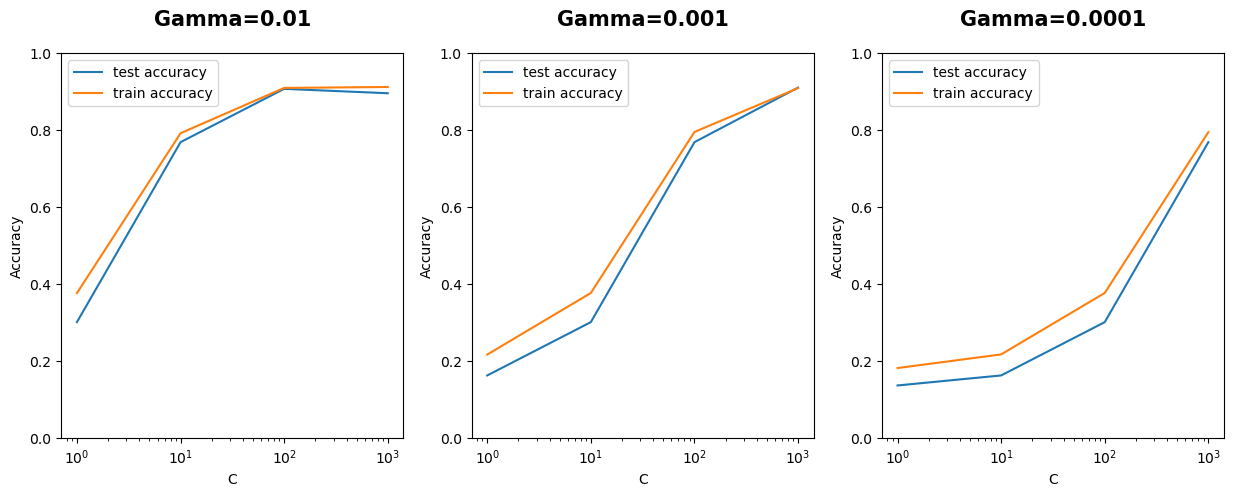

In [76]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,5))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [77]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('Tree:',tree)
print('RF:',randomforest)
print('KNN:',KNN)
print('SVC:',svc)
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Tree: 87.44588744588745
RF: 91.77489177489177
KNN: 87.44588744588745
SVC: 87.01298701298701
The best test score is 0.9104491536718646 corresponding to hyperparameters {'C': 1000, 'gamma': 0.001}


Best test score is 0.91 at Gamma = 0.001 and Gamma = 0.0001 is above 80% this by expanding the dataset the model is less overfitted, more fitted now!

# Unsupervised machine learning models - dimensionality reduction

In [81]:

def addTriUnsuMl(mldf2, weights):
    # Create a list to store the transformed data
    transformed_rows = []

    for index, row in mldf2.iterrows():
        year = row['Year']

        # Iterate through each country and mode of transport
        for column_name in mldf2.columns[1:]:  # Exclude the 'Year' column
            country, mode = column_name.split('_')

            # Calculate values for each trimester based on weights
            at_value = row[column_name]
            values = [round(at_value * weight, 2) for weight in weights]

            # Add rows to the transformed list
            for trimester, value in enumerate(values, start=1):
                new_column_name = f'{country}_{mode}'
                transformed_rows.append({'Year': year, 'Trimester': trimester, new_column_name: value})

    # Create the transformed DataFrame
    transformed_df = pd.DataFrame(transformed_rows)

    # Group by 'Year' and 'Trimester' and sum the values
    transformed_df = transformed_df.groupby(['Year', 'Trimester']).sum().reset_index()

    return transformed_df

# Example usage
weights = [0.23, 0.27, 0.24, 0.26]

mldf2 = addTriUnsuMl(mldf2, weights)
mldf2

,Year,Trimester,AT_BUS,AT_CAR,AT_TRN,BE_BUS,BE_CAR,BE_TRN,CH_BUS,CH_CAR,...,PL_TRN,PT_BUS,PT_CAR,PT_TRN,SE_BUS,SE_CAR,SE_TRN,SI_BUS,SI_CAR,SI_TRN
0,1990,1,2.53,17.73,2.74,2.44,19.16,1.40,0.85,18.88,...,7.02,4.23,16.45,2.32,2.19,19.34,1.50,7.04,14.42,1.54
1,1990,2,2.97,20.82,3.21,2.86,22.49,1.65,1.00,22.17,...,8.24,4.97,19.30,2.73,2.57,22.71,1.76,8.26,16.93,1.81
2,1990,3,2.64,18.50,2.86,2.54,19.99,1.46,0.89,19.70,...,7.32,4.42,17.16,2.42,2.28,20.18,1.56,7.34,15.05,1.61
3,1990,4,2.86,20.05,3.09,2.76,21.66,1.59,0.96,21.35,...,7.93,4.78,18.59,2.63,2.47,21.87,1.69,7.96,16.30,1.74
4,1991,1,2.44,17.71,2.85,2.46,19.16,1.40,0.90,18.65,...,5.66,4.28,16.42,2.28,2.19,19.48,1.36,6.74,15.27,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2020,4,2.42,21.19,2.39,2.13,22.10,1.79,1.51,20.77,...,1.27,1.09,24.18,0.73,2.18,21.84,1.98,1.95,23.71,0.34
124,2021,1,2.07,18.68,2.25,1.89,19.69,1.43,1.36,18.29,...,1.36,1.31,21.00,0.67,1.91,19.34,1.73,1.89,20.70,0.41
125,2021,2,2.43,21.92,2.65,2.21,23.11,1.67,1.59,21.46,...,1.59,1.54,24.65,0.78,2.24,22.71,2.03,2.21,24.30,0.49
126,2021,3,2.16,19.49,2.35,1.97,20.54,1.49,1.42,19.08,...,1.42,1.37,21.91,0.70,1.99,20.18,1.80,1.97,21.60,0.43


In [83]:
# Filter columns for CAR
mldf2_CAR = mldf2.filter(['Year', 'Trimester'] + [col for col in mldf2.columns if '_CAR' in col])
# Move 'IE_CAR' column to the thrid position
mldf2_CAR.insert(2, 'IE_CAR', mldf2_CAR.pop('IE_CAR'))

# Filter columns for BUS
mldf2_BUS = mldf2.filter(['Year', 'Trimester'] + [col for col in mldf2.columns if '_BUS' in col])
# Move 'IE_CAR' column to the thrid position
mldf2_BUS.insert(2, 'IE_BUS', mldf2_BUS.pop('IE_BUS'))

# Filter columns for TRN
mldf2_TRN = mldf2.filter(['Year', 'Trimester'] + [col for col in mldf2.columns if '_TRN' in col])
# Move 'IE_CAR' column to the thrid position
mldf2_TRN.insert(2, 'IE_TRN', mldf2_TRN.pop('IE_TRN'))

In [86]:
mldf2_CAR.head(4)

,Year,Trimester,IE_CAR,AT_CAR,BE_CAR,CH_CAR,DE_CAR,DK_CAR,EL_CAR,ES_CAR,FI_CAR,FR_CAR,HU_CAR,IT_CAR,LU_CAR,NL_CAR,PL_CAR,PT_CAR,SE_CAR,SI_CAR
0,1990,1,19.53,17.73,19.16,18.88,19.64,18.95,14.72,17.96,18.68,19.50,13.92,18.45,19.62,19.57,9.50,16.45,19.34,14.42
1,1990,2,22.92,20.82,22.49,22.17,23.06,22.25,17.28,21.09,21.92,22.90,16.34,21.65,23.03,22.98,11.15,19.30,22.71,16.93
2,1990,3,20.38,18.50,19.99,19.70,20.50,19.78,15.36,18.74,19.49,20.35,14.52,19.25,20.47,20.42,9.91,17.16,20.18,15.05
3,1990,4,22.07,20.05,21.66,21.35,22.20,21.42,16.64,20.31,21.11,22.05,15.73,20.85,22.18,22.13,10.74,18.59,21.87,16.30


In [87]:
mldf2_BUS.head(4)

,Year,Trimester,IE_BUS,AT_BUS,BE_BUS,CH_BUS,DE_BUS,DK_BUS,EL_BUS,ES_BUS,FI_BUS,FR_BUS,HU_BUS,IT_BUS,LU_BUS,NL_BUS,PL_BUS,PT_BUS,SE_BUS,SI_BUS
0,1990,1,2.65,2.53,2.44,0.85,2.09,2.60,7.45,3.43,3.10,1.38,5.70,2.97,2.35,1.86,6.49,4.23,2.19,7.04
1,1990,2,3.11,2.97,2.86,1.00,2.46,3.05,8.75,4.02,3.65,1.62,6.70,3.48,2.75,2.19,7.61,4.97,2.57,8.26
2,1990,3,2.76,2.64,2.54,0.89,2.18,2.71,7.78,3.58,3.24,1.44,5.95,3.10,2.45,1.94,6.77,4.42,2.28,7.34
3,1990,4,2.99,2.86,2.76,0.96,2.37,2.94,8.42,3.87,3.51,1.56,6.45,3.35,2.65,2.11,7.33,4.78,2.47,7.96


In [88]:
mldf2_TRN.head(4)

,Year,Trimester,IE_TRN,AT_TRN,BE_TRN,CH_TRN,DE_TRN,DK_TRN,EL_TRN,ES_TRN,FI_TRN,FR_TRN,HU_TRN,IT_TRN,LU_TRN,NL_TRN,PL_TRN,PT_TRN,SE_TRN,SI_TRN
0,1990,1,0.83,2.74,1.40,3.27,1.24,1.45,0.83,1.59,1.22,2.14,3.38,1.59,1.01,1.59,7.02,2.32,1.50,1.54
1,1990,2,0.97,3.21,1.65,3.83,1.46,1.70,0.97,1.86,1.43,2.51,3.97,1.86,1.19,1.86,8.24,2.73,1.76,1.81
2,1990,3,0.86,2.86,1.46,3.41,1.30,1.51,0.86,1.66,1.27,2.23,3.53,1.66,1.06,1.66,7.32,2.42,1.56,1.61
3,1990,4,0.94,3.09,1.59,3.69,1.40,1.64,0.94,1.79,1.38,2.42,3.82,1.79,1.14,1.79,7.93,2.63,1.69,1.74


# Hyperparameter Tuning Using Grid Search Cross-Validation

In [99]:
X = mldf2_TRN.drop(['Year', 'Trimester', 'IE_TRN'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols



In [100]:
y = mldf2_CAR.iloc[:, 2].values # Target variable

In [101]:
X

,AT_TRN,BE_TRN,CH_TRN,DE_TRN,DK_TRN,EL_TRN,ES_TRN,FI_TRN,FR_TRN,HU_TRN,IT_TRN,LU_TRN,NL_TRN,PL_TRN,PT_TRN,SE_TRN,SI_TRN
0,-0.11,-1.32,-1.32,-2.90,-1.90,1.87,0.49,-0.38,-0.47,1.06,0.75,-0.75,-2.14,3.06,2.12,-1.28,3.79
1,1.18,-0.13,-0.43,-1.95,-1.16,2.51,1.52,1.18,1.02,2.13,2.34,0.40,-1.38,3.90,2.97,-0.68,4.96
2,0.22,-1.04,-1.10,-2.64,-1.72,2.01,0.76,-0.01,-0.11,1.33,1.16,-0.43,-1.94,3.26,2.33,-1.14,4.10
3,0.85,-0.42,-0.65,-2.21,-1.34,2.37,1.25,0.81,0.66,1.86,1.93,0.08,-1.58,3.69,2.77,-0.84,4.66
4,0.19,-1.32,-1.03,-1.40,-2.11,1.87,-0.50,-0.53,-0.96,0.48,0.46,-0.56,-0.84,2.11,2.04,-1.61,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-1.07,0.53,-0.60,-1.18,-1.66,-1.22,-1.49,-2.09,-0.92,-2.23,-2.65,-1.70,-0.90,-0.93,-1.19,-0.17,-1.42
124,-1.46,-1.18,-1.18,-1.78,-1.96,-1.31,-0.92,-2.61,-0.67,-2.39,-2.65,-2.02,-1.18,-0.86,-1.32,-0.75,-1.11
125,-0.36,-0.04,-0.25,-0.67,-1.25,-1.22,-0.12,-1.42,0.82,-1.92,-1.60,-1.13,-0.22,-0.70,-1.09,-0.05,-0.77
126,-1.18,-0.89,-0.95,-1.52,-1.78,-1.31,-0.73,-2.31,-0.31,-2.27,-2.36,-1.83,-0.93,-0.82,-1.25,-0.58,-1.03


In [98]:
y

array([19.53, 22.92, 20.38, 22.07, 19.39, 22.76, 20.23, 21.92, 19.37,
       22.73, 20.21, 21.89, 19.27, 22.63, 20.11, 21.79, 19.09, 22.41,
       19.92, 21.58, 19.09, 22.41, 19.92, 21.58, 19.16, 22.49, 19.99,
       21.66, 19.16, 22.49, 19.99, 21.66, 19.18, 22.52, 20.02, 21.68,
       19.18, 22.52, 20.02, 21.68, 18.54, 21.76, 19.34, 20.96, 18.52,
       21.74, 19.32, 20.93, 18.63, 21.87, 19.44, 21.06, 18.72, 21.98,
       19.54, 21.16, 18.84, 22.11, 19.66, 21.29, 18.88, 22.17, 19.7 ,
       21.35, 18.93, 22.22, 19.75, 21.4 , 18.93, 22.22, 19.75, 21.4 ,
       18.93, 22.22, 19.75, 21.4 , 18.88, 22.17, 19.7 , 21.35, 19.  ,
       22.3 , 19.82, 21.48, 19.  , 22.3 , 19.82, 21.48, 19.04, 22.36,
       19.87, 21.53, 19.14, 22.46, 19.97, 21.63, 18.93, 22.22, 19.75,
       21.4 , 19.16, 22.49, 19.99, 21.66, 19.18, 22.52, 20.02, 21.68,
       19.  , 22.3 , 19.82, 21.48, 18.79, 22.06, 19.61, 21.24, 18.81,
       22.09, 19.63, 21.27, 19.8 , 23.25, 20.66, 22.39, 19.71, 23.14,
       20.57, 22.28]

In [103]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [104]:
# number of features
len(X_train.columns)

17

In [109]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [110]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.01,0.01,0.00,0.00,2,{'n_features_to_select': 2},-0.04,0.57,0.47,-0.42,...,0.15,0.36,38,0.39,0.23,0.25,0.44,0.22,0.30,0.09
1,0.01,0.01,0.00,0.00,3,{'n_features_to_select': 3},0.04,0.43,0.48,-0.30,...,0.17,0.29,37,0.40,0.30,0.29,0.45,0.25,0.34,0.07
2,0.01,0.01,0.00,0.00,4,{'n_features_to_select': 4},-0.01,0.48,0.52,-0.24,...,0.19,0.29,36,0.43,0.31,0.30,0.45,0.26,0.35,0.08
3,0.01,0.01,0.00,0.00,5,{'n_features_to_select': 5},0.14,0.56,0.67,-0.47,...,0.20,0.40,35,0.50,0.39,0.34,0.58,0.30,0.42,0.10
4,0.01,0.01,0.00,0.00,6,{'n_features_to_select': 6},0.15,0.50,0.69,-0.14,...,0.22,0.32,34,0.50,0.40,0.49,0.66,0.44,0.50,0.09
5,0.01,0.01,0.00,0.00,7,{'n_features_to_select': 7},0.24,0.50,0.68,-0.03,...,0.32,0.25,33,0.55,0.47,0.54,0.69,0.52,0.56,0.07
6,0.01,0.01,0.00,0.01,8,{'n_features_to_select': 8},0.56,0.60,0.66,0.01,...,0.49,0.24,32,0.65,0.63,0.59,0.74,0.62,0.65,0.05
7,0.01,0.01,0.00,0.00,9,{'n_features_to_select': 9},0.69,0.47,0.79,0.17,...,0.57,0.23,31,0.71,0.74,0.71,0.83,0.69,0.73,0.05
8,0.00,0.01,0.00,0.00,10,{'n_features_to_select': 10},0.72,0.63,0.83,0.20,...,0.63,0.22,30,0.74,0.74,0.72,0.84,0.72,0.75,0.04
9,0.01,0.01,0.00,0.00,11,{'n_features_to_select': 11},0.74,0.73,0.91,0.26,...,0.68,0.22,1,0.79,0.78,0.75,0.88,0.78,0.80,0.04


In [118]:
best_row = cv_results[cv_results['mean_test_score'] == cv_results['mean_test_score'].max()]
best_num_features = best_row['param_n_features_to_select'].values[0]

print(f"The best number of features is: {best_num_features}")


The best number of features is: 11


In [120]:
best_row = cv_results[cv_results['rank_test_score'] == 1]
best_accuracy = best_row['mean_test_score'].values[0]

print(f"The best accuracy is: {best_accuracy}")


The best accuracy is: 0.6773197489982644


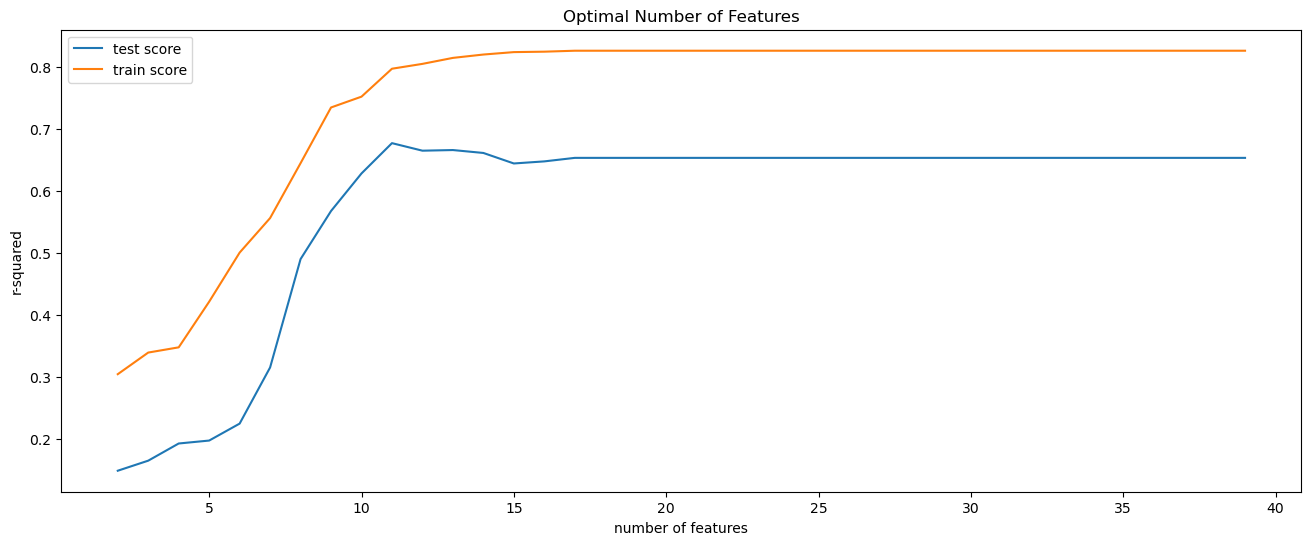

In [111]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [119]:
# final model
n_features_optimal = 11

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.3829008762627881
